### Conditional Diffusion
- 역시 조건을 넣고 Diffusion을 할 수 있어야 실제 의미가 있는 프로그램을 만들 수 있다.
- 우선 텍스트를 넣는 과정을 하기 전에, 먼저 간단하게 Mnist 숫자만 Label로 넣어보자.
- Time Embedding 에 Label Vector 를 더합니다.
  - 둘 다 전역 조건이고 모든 레이어에 동일하게 적용 할 수 있기 때문.
  - embedding space에서 더해도 논리적으로 문제 없음
  - 구현도 단순
  - Stable Diffusion 이 이 방식이다.
  - 다음 장에서 Stable Diffusion을 구현 해 볼 것이다

In [1]:
import math
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device: cuda


torch.Size([128, 1, 28, 28]) tensor([1, 2, 8, 5, 2, 6, 9, 9, 9, 4])


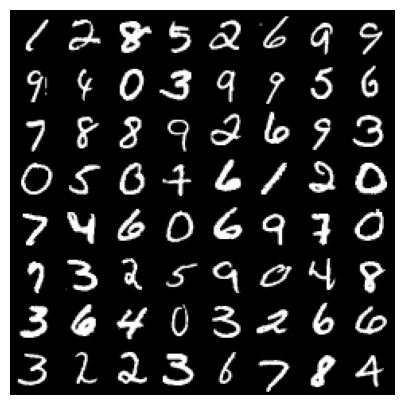

In [2]:
batch_size = 128

class ToMinusOneToOne:
    def __call__(self, x):
        return x * 2 - 1

transform = transforms.Compose([
    transforms.ToTensor(),
    ToMinusOneToOne(),
])

train_ds = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

x0, y0 = next(iter(train_loader))
print(x0.shape, y0[:10])

grid = utils.make_grid((x0[:64] + 1) / 2, nrow=8)
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()

In [3]:
T = 1000

def make_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

betas = make_beta_schedule(T).to(device)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - alphas_bar)

def extract(a, t, x_shape):
    b = t.size(0)
    return a.gather(0, t).reshape(b, *((1,) * (len(x_shape) - 1)))

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    xt = (
        extract(sqrt_alphas_bar, t, x0.shape) * x0 +
        extract(sqrt_one_minus_alphas_bar, t, x0.shape) * noise
    )
    return xt, noise

In [4]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        return torch.cat([emb.sin(), emb.cos()], dim=1)

class TimeMLP(nn.Module):
    def __init__(self, tdim):
        super().__init__()
        self.net = nn.Sequential(
            SinusoidalPosEmb(tdim),
            nn.Linear(tdim, tdim * 4),
            nn.SiLU(),
            nn.Linear(tdim * 4, tdim),
        )

    def forward(self, t):
        return self.net(t)

In [5]:
class ResBlock(nn.Module):
    def __init__(self, ch, tdim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, ch)
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(8, ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.dropout = nn.Dropout(dropout)

        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(tdim, ch)
        )

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.conv2(self.dropout(F.silu(self.norm2(h))))
        return x + h


class Downsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        return self.conv(x)


class AttnBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.norm = nn.GroupNorm(8, ch)
        self.q = nn.Conv2d(ch, ch, 1)
        self.k = nn.Conv2d(ch, ch, 1)
        self.v = nn.Conv2d(ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        n = h * w

        h_ = self.norm(x)
        q = self.q(h_).reshape(b, c, n).permute(0, 2, 1)
        k = self.k(h_).reshape(b, c, n)
        v = self.v(h_).reshape(b, c, n).permute(0, 2, 1)

        attn = torch.bmm(q, k) * (c ** -0.5)
        attn = torch.softmax(attn, dim=-1)

        out = torch.bmm(attn, v)
        out = out.permute(0, 2, 1).reshape(b, c, h, w)

        return x + self.proj(out)


In [6]:
class ConditionalUNet(nn.Module):
    def __init__(self, num_classes=10, base_ch=64, tdim=128, dropout=0.1, attn_levels=("mid", "14")):
        """
        attn_levels:
          - "14": 14x14 feature에서 attention
          - "7":  7x7 feature에서 attention
          - "mid": bottleneck에서 attention
        """
        super().__init__()
        self.time_mlp = TimeMLP(tdim)
        self.label_emb = nn.Embedding(num_classes, tdim)

        self.in_conv = nn.Conv2d(1, base_ch, 3, padding=1)

        # 28x28
        self.res1a = ResBlock(base_ch, tdim, dropout)
        self.res1b = ResBlock(base_ch, tdim, dropout)
        self.down1 = Downsample(base_ch)   # 28 -> 14

        # 14x14
        self.res2a = ResBlock(base_ch, tdim, dropout)
        self.res2b = ResBlock(base_ch, tdim, dropout)
        self.attn14 = AttnBlock(base_ch) if ("14" in attn_levels) else nn.Identity()
        self.down2 = Downsample(base_ch)   # 14 -> 7

        # 7x7 (pre-mid)
        self.attn7 = AttnBlock(base_ch) if ("7" in attn_levels) else nn.Identity()

        # bottleneck 7x7
        self.mid_in = nn.Conv2d(base_ch, base_ch * 2, 3, padding=1)
        self.mid1 = ResBlock(base_ch * 2, tdim, dropout)
        self.mid_attn = AttnBlock(base_ch * 2) if ("mid" in attn_levels) else nn.Identity()
        self.mid2 = ResBlock(base_ch * 2, tdim, dropout)
        self.mid_out = nn.Conv2d(base_ch * 2, base_ch, 3, padding=1)

        # up 7->14
        self.up2 = Upsample(base_ch)
        self.up2_conv = nn.Conv2d(base_ch + base_ch, base_ch, 3, padding=1)
        self.ures2a = ResBlock(base_ch, tdim, dropout)
        self.ures2b = ResBlock(base_ch, tdim, dropout)
        self.uattn14 = AttnBlock(base_ch) if ("14" in attn_levels) else nn.Identity()

        # up 14->28
        self.up1 = Upsample(base_ch)
        self.up1_conv = nn.Conv2d(base_ch + base_ch, base_ch, 3, padding=1)
        self.ures1a = ResBlock(base_ch, tdim, dropout)
        self.ures1b = ResBlock(base_ch, tdim, dropout)

        self.out_norm = nn.GroupNorm(8, base_ch)
        self.out = nn.Conv2d(base_ch, 1, 1)

    def forward(self, x, t, y):
        t_emb = self.time_mlp(t) + self.label_emb(y)

        x = self.in_conv(x)

        # down 28
        x1 = self.res1b(self.res1a(x, t_emb), t_emb)  # skip 28
        x = self.down1(x1)                            # 14

        # down 14
        x2 = self.res2b(self.res2a(x, t_emb), t_emb)  # skip 14
        x2 = self.attn14(x2)                          # attention @14
        x = self.down2(x2)                            # 7

        # 7
        x = self.attn7(x)                             # attention @7 (optional)

        # mid
        x = self.mid_in(x)
        x = self.mid1(x, t_emb)
        x = self.mid_attn(x)                          # attention @bottleneck
        x = self.mid2(x, t_emb)
        x = self.mid_out(x)

        # up 7->14
        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.up2_conv(x)
        x = self.ures2b(self.ures2a(x, t_emb), t_emb)
        x = self.uattn14(x)                           # attention @14 on up path

        # up 14->28
        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1_conv(x)
        x = self.ures1b(self.ures1a(x, t_emb), t_emb)

        x = F.silu(self.out_norm(x))
        return self.out(x)


In [7]:
model = ConditionalUNet().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

epochs = 20
log_every = 100

for ep in range(1, epochs + 1):
    model.train()
    total = 0.0
    n = 0
    start = time.time()

    for step, (x0, y) in enumerate(train_loader, start=1):
        x0 = x0.to(device)
        y = y.to(device)

        t = torch.randint(0, T, (x0.size(0),), device=device)
        xt, noise = q_sample(x0, t)

        pred = model(xt, t, y)
        loss = F.mse_loss(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        total += loss.item() * x0.size(0)
        n += x0.size(0)

        if step % log_every == 0:
            print(f"[ep {ep} | step {step}] loss={loss.item():.4f}")

    print(f"[ep {ep} DONE] avg_loss={total/n:.4f}, time={time.time()-start:.1f}s")


[ep 1 | step 100] loss=0.0896
[ep 1 | step 200] loss=0.0600
[ep 1 | step 300] loss=0.0608
[ep 1 | step 400] loss=0.0480
[ep 1 DONE] avg_loss=0.0829, time=21.1s
[ep 2 | step 100] loss=0.0436
[ep 2 | step 200] loss=0.0368
[ep 2 | step 300] loss=0.0530
[ep 2 | step 400] loss=0.0327
[ep 2 DONE] avg_loss=0.0407, time=22.4s
[ep 3 | step 100] loss=0.0356
[ep 3 | step 200] loss=0.0350
[ep 3 | step 300] loss=0.0359
[ep 3 | step 400] loss=0.0468
[ep 3 DONE] avg_loss=0.0339, time=22.4s
[ep 4 | step 100] loss=0.0283
[ep 4 | step 200] loss=0.0293
[ep 4 | step 300] loss=0.0328
[ep 4 | step 400] loss=0.0296
[ep 4 DONE] avg_loss=0.0311, time=22.2s
[ep 5 | step 100] loss=0.0262
[ep 5 | step 200] loss=0.0279
[ep 5 | step 300] loss=0.0279
[ep 5 | step 400] loss=0.0268
[ep 5 DONE] avg_loss=0.0291, time=22.2s
[ep 6 | step 100] loss=0.0251
[ep 6 | step 200] loss=0.0303
[ep 6 | step 300] loss=0.0300
[ep 6 | step 400] loss=0.0254
[ep 6 DONE] avg_loss=0.0275, time=22.2s
[ep 7 | step 100] loss=0.0220
[ep 7 | st

In [8]:
os.makedirs("./ckpt", exist_ok=True)
torch.save(model.state_dict(), "./ckpt/ddpm_mnist_conditional.pt")

In [9]:
# 로드 예시
model.load_state_dict(torch.load("./ckpt/ddpm_mnist_conditional.pt", map_location=device))
model.eval()

ConditionalUNet(
  (time_mlp): TimeMLP(
    (net): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=128, out_features=512, bias=True)
      (2): SiLU()
      (3): Linear(in_features=512, out_features=128, bias=True)
    )
  )
  (label_emb): Embedding(10, 128)
  (in_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res1a): ResBlock(
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (dropout): Dropout(p=0.1, inplace=False)
    (time_proj): Sequential(
      (0): SiLU()
      (1): Linear(in_features=128, out_features=64, bias=True)
    )
  )
  (res1b): ResBlock(
    (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm2): GroupNorm(8, 64, eps

In [10]:
@torch.no_grad()
def sample_conditional(label, n=64):
    model.eval()
    x = torch.randn(n, 1, 28, 28, device=device)
    y = torch.full((n,), label, device=device, dtype=torch.long)

    for t in reversed(range(T)):
        t_vec = torch.full((n,), t, device=device, dtype=torch.long)
        eps = model(x, t_vec, y)

        beta = betas[t]
        alpha = alphas[t]
        abar = alphas_bar[t]

        mean = (1 / torch.sqrt(alpha)) * (x - beta / torch.sqrt(1 - abar) * eps)
        if t > 0:
            x = mean + torch.sqrt(beta) * torch.randn_like(x)
        else:
            x = mean

    return x


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03058505..1.0375975].


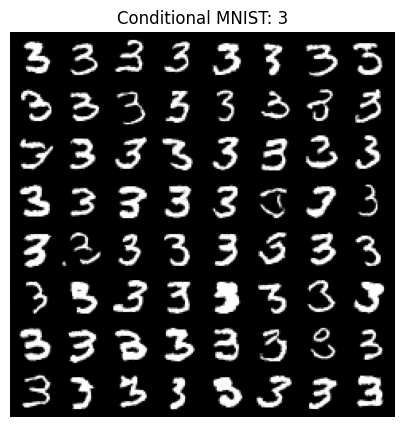

In [11]:
digit = 3
samples = sample_conditional(digit)

grid = utils.make_grid((samples + 1) / 2, nrow=8)
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1,2,0).cpu())
plt.title(f"Conditional MNIST: {digit}")
plt.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.038061738..1.0551099].


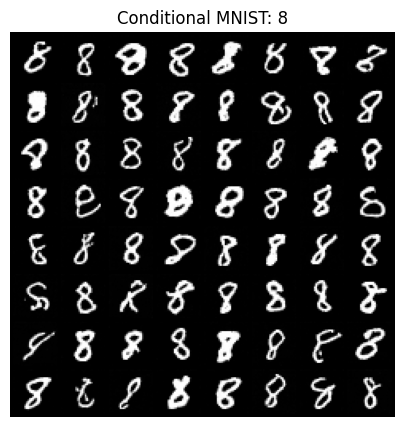

In [12]:
digit = 8
samples = sample_conditional(digit)

grid = utils.make_grid((samples + 1) / 2, nrow=8)
plt.figure(figsize=(5,5))
plt.imshow(grid.permute(1,2,0).cpu())
plt.title(f"Conditional MNIST: {digit}")
plt.axis("off")
plt.show()
